# **Load in some Libraries**

In [39]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from torch.utils.data import Dataset
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import transforms

# **Load in CSV of watermark data** 

In [5]:
df = pd.read_csv('Image specification for AI training - Sheet1 (3).csv')

# **Mount Google Drive**

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# **Formatting Data into dictionaries** 

In [19]:
#list of images
image_paths = df['Path'].tolist()
del image_paths[2500:]
print(len(image_paths))

2500


In [20]:
#Replace the path names so that it's in the format that takes the images from google drive
for image in range(len(image_paths)):
  image_paths[image] = image_paths[image].replace('C:\\Users\\leeeg\\Downloads\\student_data\\student_data', '/gdrive/My Drive/student_data/')
  image_paths[image] = image_paths[image].replace('//',"/")
  image_paths[image] = image_paths[image].replace('\\',"/")
len(image_paths)

2500

In [23]:
#list of labels
labels = []
for i in range(2500):
  row = df.iloc[i]

# Search for the letter 'x' in the row for the csv

  for i, element in enumerate(row):
      if 'x' in str(element) and i != 0:
          labels.append(i)
          break
len(labels)

2500

In [24]:
everything_dictionary = {}
for name in image_paths:
    everything_dictionary[name] = labels[image_paths.index(name)]

len(everything_dictionary)

2500

# **Stratify the Data**

In [28]:
label_counts = {}
train = {}
val = {}
for image, label in everything_dictionary.items():
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1

for image, label in everything_dictionary.items():
    if label_counts[label] % 5 == 0: #because 20% of the time the remainder is 5
        val[image] = label
    else:
        train[image] = label
    label_counts[label] -= 1
train = {k: v for k, v in sorted(train.items(), key=lambda item: item[1])}
val = {k: v for k, v in sorted(val.items(), key=lambda item: item[1])}

print(train)
print(val)

{'/gdrive/My Drive/student_data//cs_scrapped/pigmented-lesions-benign_naevus-achromic/65357.png': 1, '/gdrive/My Drive/student_data//cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/26909.png': 1, '/gdrive/My Drive/student_data//cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/115252.png': 1, '/gdrive/My Drive/student_data//cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/115944.png': 1, '/gdrive/My Drive/student_data//cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/103710.png': 1, '/gdrive/My Drive/student_data//cs_scrapped/inflammatory_infections_viral-diseaseshpv-herpes-molluscum-exanthems-and-others_herpes-simplex_eczema-herpeticum/31253.png': 1, '/gdrive/My Drive/student_data//cs_s

In [26]:
len(train) #isn't going to be exactly 80% bc some of the classes only have one image idk what to do about that

2015

In [30]:
len(val)

485

# **Visualize the different Classes**

In [33]:
def bargraph(dictionary): 

  keys = list(dictionary.keys())
  values = list(dictionary.values())


  # Create frequency dictionary
  frequency = {}
  for value in values:
      if value in frequency:
          frequency[value] += 1
      else:
          frequency[value] = 1

  # Get frequency keys and values
  f_keys = list(frequency.keys())
  f_values = list(frequency.values())

  # Create bar graph
  fig, ax = plt.subplots()
  ax.bar(f_keys, f_values, color = '#8B0000', alpha = 0.5)

  # Add title and labels
  plt.title('Frequency of Different Labels in the Train Dataset')
  plt.xlabel('Watermark labels')
  plt.ylabel('Frequency')

  # Rotate x-axis labels
  plt.xticks(rotation=90)

  # Show graph
  plt.show()

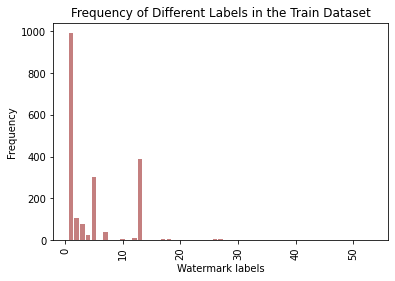

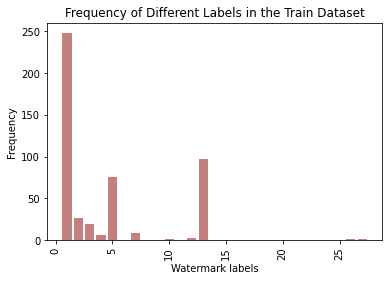

In [35]:
bargraph(dictionary = train)
bargraph(dictionary = val)

# **Checks if there is any data leakage**

In [36]:
combined_dict = {**train, **val}
combined_dict

duplicate_keys = [key for key, value in combined_dict.items() if key in train and key in val]

if duplicate_keys:
    print("Duplicate keys found: ", duplicate_keys)
else:
    print("No duplicate keys found.")
len(combined_dict)

No duplicate keys found.


2500

# **Preprocess data** 

In [47]:
cudnn.benchmark = True
plt.ion()   # interactive mode

In [48]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths_dict, transforms=None):
        super().__init__()
        self.image_paths_dict = image_paths_dict
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths_dict)

    def __getitem__(self, index):
        image_paths = list(self.image_paths_dict.keys())[index]
        label = list(self.image_paths_dict.values())[index]

        try:
            image = Image.open(image_paths).convert('RGB')

        except:
            # save to file
            random_idx = np.random.choice(len(image_paths))
            with open('none_importable_images.txt','a+') as fh:
                fh.write(image_paths +',' + image_paths[random_idx] + '\n')
            return self.__getitem__(random_idx)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

In [49]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CustomImageDataset(image_paths_dict = train, transforms=data_transforms['train'])
val_dataset = CustomImageDataset(image_paths_dict = val, transforms=data_transforms['val'])

# Create a dictionary of dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)
}

# Get the size of the datasets
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Get the class names
class_names = train_dataset.image_paths_dict.values()

# Get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Train the model**

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10) 

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **Visualize the models outputs**

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {list(class_names)[preds[j]]}') #transfer to cpu
                #imshow(inputs.cpu().data[j])
                imshow(transforms.ToPILImage()(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Define some parameters**

In [52]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 54)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# **Run the model**

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1190 Acc: 0.7062
val Loss: 0.2155 Acc: 0.9505

Epoch 1/24
----------


In [45]:
torch.save(model_ft.state_dict(), "/gdrive/My Drive/watermark_model.pt")

NameError: ignored

In [ ]:
visualize_model(model, num_images=6)

AttributeError: ignored

In [ ]:
!pip install umap-learn

In [46]:
model = torch.load('/gdrive/My Drive/watermark_model.pt')

In [ ]:
#pass data thru
#get hidden features
### strip the last layer
feature_extractor = torch.nn.Sequential(*list(model.values())[:-1])
### check this works
x = torch.randn([1,3,224,224])
output = feature_extractor(x) # output now has the features corresponding to input x
print(output.shape)

TypeError: ignored